## Proyecto 1 - FFT y Procesamiento de audio
**EL3203-1 Primavera 2024 Análisis de señales, FCFM - UChile**<br>
**Profesor:** Jorge Silva<br>
**Auxiliares:** Eduardo Oñate y Simón Yáñez<br>
**Ayudantes:** Maximiliano Rojas, Luciano Vidal y Claudio Zúniga<br>


**Grupo:** [N° de grupo]<br>
**Integrantes:** Fernando Muñoz, Felipe González

### Introducción e instrucciones
El presente notebook corresponde a aquel con el que usted debe trabajar a modo de realizar sus implementaciones. Los comentarios de este archivo son solo un complemento al enunciado que se le adjuntó, es decir, las instrucciones del PDF de enunciado prevalecen por sobre las de este *notebook*. Cualquier duda la puede preguntar (preferentemente) por el foro del curso, por correo o en clases.

Se le recomienda cargar este Notebook en Google Colaboratory para evitar cualquier problema de dependencias que pueda tener. La idea es que en su entrega final, el *notebook* esté en un estado tal que sus celdas puedan ser **ejecutadas secuencialmente** sin errores ni necesidad de modificar su código.

In [2]:
# Importe de librerías
from scipy.io.wavfile import read, write  # Manejo con archivos .wav
import matplotlib.pyplot as plt           # Visualización
import numpy as np                        # Procesamiento de datos
from IPython.display import Audio         # Necesaria para escuchar audios

In [ ]:
# Semilla aleatoria (permite reproducir los resultados)
np.random.seed(31415)

#### Generación de señal sintética y demostración de espectrograma
A continuación se generará una señal sintética directamente a partir de las funciones de numpy. La idea de esta es que usted pueda probar las funciones que programe y compararlas con las implementaciones de librerías ya establecidas, en una implementación correcta, los resultados deberían ser muy similares a los ejemplos mostrados aquí.

In [ ]:
# Generación de la señal
dt = 0.0005                   # Delta tiempo (muestreo)
t = np.arange(0.0, 20.0, dt)  # Arreglo base (eje temporal)
s1 = np.sin(2*np.pi*100*t)    # Sinusoide de amplitud 1 y frecuencia 100
s2 = 2*np.sin(2*np.pi*400*t)  # Sinusoide de doble amplitud y frecuencia 400

In [ ]:
# Creación de un chirrido transiente
s2[t <= 3] = s2[17 <= t] = 0
s2[np.logical_and(6 <= t, t <= 10)] = 0

In [ ]:
# Adición de ruido a la señal
nse = 1*np.random.random(size=len(t))

In [ ]:
# Construcción de la señal y frecuencia de muestreo
x = s1 + s2 + nse  # Señal completa
NFFT = 1024        # Longitud de las ventanas de muestras (0.512 s)
Fs = int(1.0/dt)   # Frecuencia de muestreo 2000

Con la señal ya construída (presente en la variable ```x```), se procede a mostrar la señal tanto en el dominio del tiempo, como su espectrograma (revisar definición en enunciado), notar que parte de su trabajo es replicar parcialmente el método ```plt.specgram```, la documentación de este método la puede encontar en https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.specgram.html.

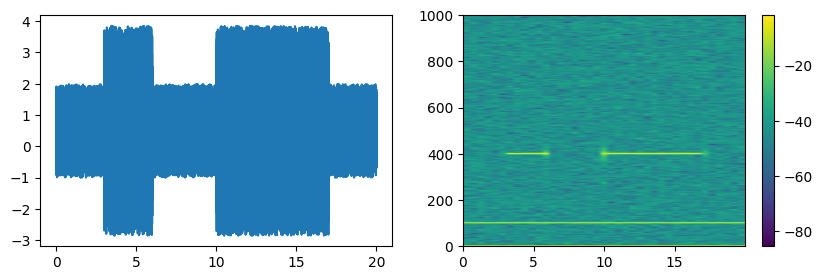

In [ ]:
# Se genera una figura con dos subfiguras
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,3))

# La primera subfigura corresponde a la gráfica de la señal en el dominio del tiempo
ax1.plot(t, x)

# Se genera el espectrograma usando el método specgram
'''
Esta ejecución de specgram toma como parámetros
    x        : Arreglo de valores de señal (datos)
    Fs       : Frecuencia de muestreo (usado para calcular los valores de freqs)
    NFFT     : Tamaño en muestras de cada subconjunto de datos sobre los que se aplica FFT
    noverlap : Corresponde a la cantidad de muestras que se superponen entre bloques, por simplicidad, será 0
'''
Pxx, freqs, bins, im = ax2.specgram(x, NFFT=1024, Fs=Fs, noverlap=0)

fig.colorbar(im)

# Muestra los gráficos
plt.show()

Como puede notar, esta señal sintética se compone de un sonido de 100 Hz constante y dos sonidos de 400 Hz de mayor amplitud intermitentes. A continuación se define una función que dada una señal, permite guardar la misma y escucharla. Esta función le será útil en las últimas partes del enunciado.

In [ ]:
def guardar_wav(nombre, signal, Fs):
    '''
    La función guardar_wav toma como argumentos una señal de audio (signal), su frecuencia de muestreo (Fs) un nombre de
    archivo deseado (nombre), en base a lo anterior la señal realiza la normalización y conversión del contenido de la
    señal, a modo de guardarla en el directorio local con el nombre [nombre].wav
    '''
    # Amplitud máxima del formato 16-bit PCM
    amplitud_max = np.iinfo(np.int16).max

    # Obtención del máximo valor absoluto de la señal normalizada
    max_val = max(abs(signal))

    # Normalización de la señal
    signal_norm = amplitud_max*(signal/max_val)

    # Transformación a arreglo de enteros de 16 bits
    signal_procesada = np.array(signal_norm, dtype="int16")

    # ¡Guardado de la señal en un archivo escuchable!
    write(f"{nombre}.wav", Fs, signal_procesada)

Si ejecuta la siguiente celda, se guardará el audio sintético en el archivo ```sintético.wav``` en el mismo directorio que este notebook a modo que pueda escucharlo.

In [ ]:
guardar_wav("sintético", x, Fs)

#### Demostración de función FFT

Antes de que usted comience a implementar sus funciones, a continuación se muestra que lo que mas menos se espera que usted obtenga, efectivamente tanto las funciones ```DFT```, ```FFT``` y ```FFT2``` deben tener el mismo resultado que la función ```numpy.fft.fft```, a modo de verificar lo anterior, a continuación se muestra el resultado de la función de ```numpy``` aplicada sobre una ventana temporal de la señal sintética donde se espera un *peak* en las frecuencias equivalentes a 100 Hz y 400 Hz.

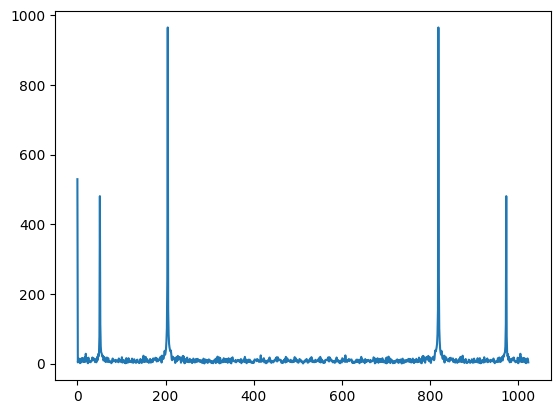

In [ ]:
# Transformada FFT de numpy en una ventana única
numpy_fft_test = np.fft.fft(x[10240:10240+1024])

# Gráfica de la ventana de señal en dominio de frecuencia
plt.plot(np.abs(numpy_fft_test))
plt.show()

Como se puede ver en la gráfica, se muestran dos *peaks* de gran amplitud, dos *peaks* de menor amplitud y uno en cero. Recordar las propiedades de simetría del espectro al trabajar con señales reales y la forma en que se realizan las conversiones de coeficientes de Fourier a frecuencias continuas segun la frecuencia de muestreo utilizada, esto muestra que el resultado es el esperado.

### Implementación de funciones relacionadas a FFT
A continuación se encuentran los bloques donde usted debe implementar las funciones relacionadas a FFT, a modo de facilitar su propia revisión de los resultados.

**Función ```W```**: Implemente a continuación la función planteada en el punto (6.a).

In [4]:
def W(N):
    omega = (-2*np.pi/N) * (1j)
    return np.exp(omega)

**Función ```DFT```**: Implemente a continuación la función planteada en el punto (6.b).

In [3]:
def DFT(x):
    N = len(x)
    n = np.arange(N)
    k = n.reshape((N, 1))
    W = np.exp(-2j * np.pi * k * n / N)

    return np.dot(W,x)

**Función ```FFT```**: Implemente la función planteada en el punto (6.c).

In [7]:
def FFT(x, L, M): # FFT con el primer método visto
    N = len(x)
    assert L*M == N
    x = x.reshape(L, M)

    F_lq = np.zeros((L, M), dtype=complex) # Cálculo de F[l, q]

    for l in range(L):
      F_lq[l] = DFT(x[l])

    G_lq = np.zeros((L, M), dtype=complex) # Cálculo de G[l, q]

    for l in range(L):
      for q in range(M):
        G_lq[l, q] = W(N)**(l*q) * F_lq[l, q]

    X_pq = np.zeros((L, M), dtype=complex) # Cálculo de X[p, q]

    for q in range(M):
      X_pq[:, q] = DFT(G_lq[:, q])

    return X_pq.reshape(N)








**Función ```FFT2```**: Implemente la función planteada en el punto (6.d).

In [13]:
def FFT2(x):
  N = len(x)
  if N == 1: # Caso de salida para cuando se alcanzan las FFT de tamaño 1
    return x
  x_par, x_impar = x[0::2], x[1::2]
  y_par, y_impar = FFT2(x_par), FFT2(x_impar) # Cada FFT puede dividirse en componentes pares e impares, de ahí la recursión
  y = np.zeros(N, dtype=complex)
  for i in range (int(N/2)): # Cálculo de los términos de la FFT, aprovechando la simetría del problema
    y[i] = y_par[i] + W(N)**i * y_impar[i]
    y[i + int(N/2)] = y_par[i] - W(N)**i * y_impar[i]
  return y


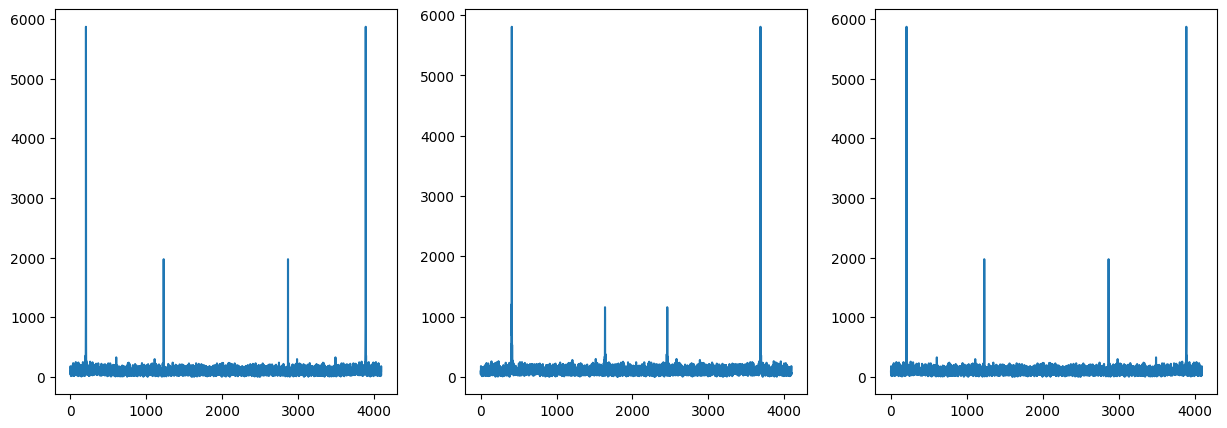

In [15]:
# Se crea la señal de prueba

n = np.linspace(0, 5, 5000)

sample = (3 * np.sin(2 * np.pi * 50 * n) + np.sin(2 * np.pi * 300 * n) + np.random.uniform(-3, 3, 5000))[:4096]

# Se ejecutan las distintas variaciones de la transformada de Fourier sobre este conjunto de prueba

Y1 = DFT(sample)
Y2 = FFT(sample, 2048, 2)
Y3 = FFT2(sample)

fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.plot(np.abs(Y1))
ax2.plot(np.abs(Y2))
ax3.plot(np.abs(Y3))

plt.show()


A continuación, cree la señal solicitada en el punto en el punto (6.e) y ejecuta las pruebas requeridas.

### Implementación de funciones relacionadas a espectrograma
A continuación se encuentran los bloques donde usted debe implementar las funciones relacionadas a espectrogramas, la idea es que el resultado final usted lo pueda comparar con el espectrograma de la señal sintética que se muestra al principio de este notebook y en el enunciado de este proyecto.

**Función ```espectrograma_complejo```**: Implemente la función planteada en el punto (8.a).<br>
Entendiendo que cada columna resultante de este espectrograma corresponde a la FFT2 de una ventana temporal de la señal original, para probar lo obtenido se puede extraer una de las columnas de este espectrograma complejo generado y comparar la gráfica de su valor absoluto con las gráficas de FFT de las partes anteriores

In [ ]:
def espectrograma_complejo(x, NFFT):
    pass

**Función ```espectrograma_real```**: Implemente la función planteada en el punto (8.b).<br>
Para probar esta función puede directamente mostrar la matriz resultante con ```plt.imshow```.

In [ ]:
def espectrograma_real(x, NFFT):
    pass

# plt.imshow(espectrograma_real(x, 1024), aspect=0.04)

*Función ```espectrograma_limites```*: A continuación se muestra la función ```espectrograma_limites``` descrita en el enunciado, que le será de utilidad al momento de programar la función ```espectrograma_grafica```. En el bloque se encuentra un ```print``` que le permitirá verificar los límites de espectrograma para la señal sintética sabiendo que tiene una duración de 20 segundos y el rango de frecuencias del espectrograma resultantes corresponde a [0 Hz, 1000 Hz].

In [ ]:
def espectrograma_limites(N, NFFT, Fs):
    duracion = N/Fs
    return (0, duracion, 0, Fs//2)

print(espectrograma_limites(len(x), 1024, Fs))

(0, 20.0, 0, 1000)


**Función ```espectrograma_grafica```**: implemente la función planteada en el punto (8.c).<br>
Puede utilizar como referencia del resultado deseado la figura 1 del enunciado de este proyecto.

In [ ]:
def espectrograma_grafica(x, NFFT, Fs, is_log):
    pass

**Pruebas de la función ```espectrograma_grafica```**: Realice las gráficas de prueba descritas en el punto (8.d).<br>
Recuerde que la idea de la función ```espectrograma_grafica``` es que esta muestre directamente una gráfica con todo lo pedido en el *notebook* al ser ejecutada.

In [ ]:
# Prueba con is_log de valor True
#   . . .

In [ ]:
# Prueba con is_log de valor False
#   . . .

### Experimentos finales
En esta última sección se le pide realizar breves experimentos con los archivos de audio que fueron subidos a material docente, estos archivos están en formato `.wav` y muestreados a 44.1 KHz. Se recomienda altamente que los escuche para que se haga una idea de los datos con los que está trabajando.

A continuación se define una función que le permitirá obtener de forma sencilla un arreglo numérico a partir de un archivo de audio en el formato ya descrito.

In [ ]:
def leer_wav(nombre):
    '''
    La función leer_wav como podrá notar corresponde a la función scipy.io.wavfile.read, y se está definiendo solo con
    fines de hacer explícito el contrato de esta úlitma. Esta función toma un string correspondiente al nombre de un
    archivo de audio (nombre) y retorna una tupla de la forma: (Fs, datos); donde Fs corresponde a la frecuencia de
    muestreo del archivo y datos corresponde al arreglo de numpy que contiene los valores de las muestras del mismo.
    '''
    return read(nombre)

Como ejemplo, a continuación se muestra la subida y lectura del audio que contiene una grabación de voz, además de utilizar la función `Audio` de la librería `IPython.display` para escucharlo.

Estos bloques los puede replicar más adelante según lo pedido.

In [ ]:
# Se sube el archivo desde el almacenamiento local
# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('Se subió archivo "{name}" de tamaño {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

In [ ]:
# Se lee el archivo con la función entregada
Fs_voz, signal_voz = leer_wav('Audios/voz.wav')

# Se escucha el audio
Audio(data=signal_voz, rate=Fs_voz)

En las siguientes partes utilice la cantidad de bloques que sean necesarios para mostrar los resultados pedidos.

**Gráfica grabación de voz**: Realice el experimento indicado en la parte (9.a).

In [ ]:
# Lea el fichero de audio que contiene la grabación de voz y realice las 5 gráficas pedidas

**Gráfica de 4 señales**: Realice el experimento indicado en la parte (9.b).

In [ ]:
# Lea cada uno de los cuatro audios y grafíquelos según se le indica

Antes de comenzar a realizar los siguientes experimentos, note que a continuación se define una función que le permitirá resconstruir el archivo de audio que se genere a partir del espectrograma complejo. La idea es que usted utilice esta función a modo de poder escuchar los resultados del procesamiento que realice.

In [ ]:
def reconstruir_audio(nombre, espectrograma_complejo, Fs=None, save=False):
    '''
    Función que permite reconstruir un archivo de audio a partir de un espectrograma complejo, los parámetros con los que
    opera esta función corresponden a:
        nombre        : String que corresponde al nombre de guardado del el archivo .wav en el directorio local
        spec_complejo : Espectrograma complejo con el formato resultante de la función espectrograma_complejo(...),
                        definido formalmente en el enunciado del proyecto
        Fs            : Frecuencia de muestro de la información original contenida en el espectrograma en Hz
        save          : Valor booleano que en caso de ser True guarda el audio como archivo, no lo hace en caso contrario
    Esta función por un lado retorna el arreglo de numpy correspondiente al audio reconstruido y por otro, guarda en el
    directorio la reconstrucción en el archivo nombre.wav, lo cual permite escucharlo con cualquier reporductor de audio
    '''
    # Verifica en caso que el archivo se quiera guardar como archivo, la frecuencia de muestreo esté especificada
    if Fs is None and save:
        raise ValueError("Se debe especificar valor de frec. de muestreo (Fs) en caso que se desee guardar el archivo")

    # Obtención de dimensiones del espectrograma a modo de definir la señal a guardar
    NFFT = espectrograma_complejo.shape[0]
    N_ventanas = espectrograma_complejo.shape[1]
    signal = np.zeros(NFFT*N_ventanas)

    # La recosntrucción se hace obteniendo la transformada FFT inversa para cada ventana y concatenando la señal resultante
    for j in range(N_ventanas):
        # Se obtiene el vector de FFT asociado a la columna j
        vector_FFT = espectrograma_complejo[:,j]
        # Se aplica FFT inversa y se desprecian las componentes imaginarias resultantes de errores numéricos
        subarreglo = np.real(np.fft.ifft(vector_FFT))
        # Se almacena el subarreglo en la porción temporal de la señal construida correspondiente
        signal[j*NFFT:(j+1)*NFFT] = subarreglo

    if save:
        guardar_wav(nombre, signal, Fs)

    return signal

**Separación de audio de bajo**: Realice el experimento indicado en la parte (9.c).



In [ ]:
# Implemente el filtrado pasabajos
# Grafique el espectrograma pedido
# Genere lo audios pedidos

**Separación de audio de guitarra**: Realice el experimento indicado en la parte (9.d).


In [ ]:
# Implemente el filtrado pasaaltos
# Grafique el espectrograma pedido
# Genere lo audios pedidos